![jolie image](img/download.jpg)
# Livrable 3
## Captioning

## Groupe de projet 1 :
- Rémi Papin
- Fabien Richard
- Zacharia Azzouzi

## Introduction

Dans ce troisième livrable nous allons réaliser du Captioning, c'est-à-dire la génération automatique des légendes. Nous utiliserons deux techniques avancées de Machine Learning :
- les réseaux de neurones récurrents (RNN);
- les réseaux de neurones convolutifs (CNN).

Les RNN permettent de générer les étiquettes, il sera nécessaire de passer avant par des CNN pour prétraiter les images. Cela va nous permettre d'identifier les zones d'intérêt dans les images, et de représenter les images en question de manière plus compacte (Ceci nous permet de ne pas charger l'ensemble des images en RAM).

Nous Nous appuierons sur des datasets d'étiquetage classiques pour effectuer l'apprentissage supervisé.

De plus Nous fusionnons les livrable 1, 2 et 3 de façon à obtenir un projet automatisé.
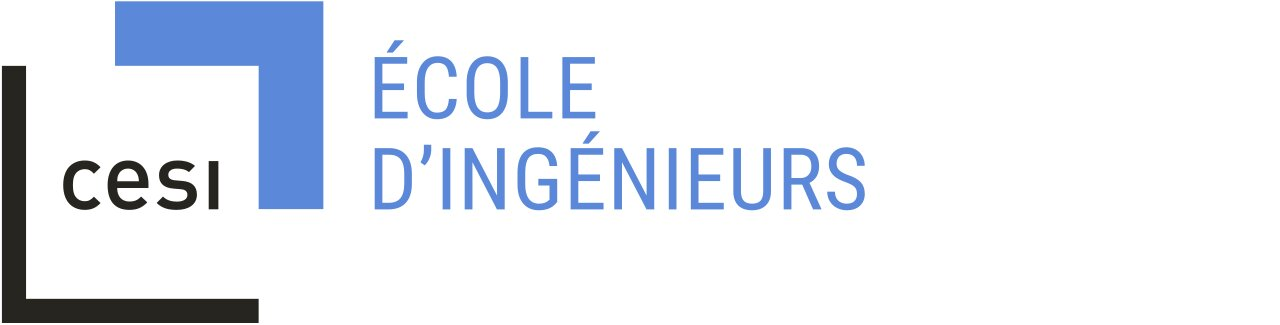

In [35]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm
import configuration
import ClassificationBinaire
import Denoising
import cv2

data_dir = configuration.data_dir
image_to_test_dir = configuration.image_to_test_dir
image_h = 304
image_w = 304

## Classification

Chargement du modèle de classification pour determiner si l'image est une photo ou non

In [36]:
binary_classifier = ClassificationBinaire.ClassificationBinaire(180, 180, 2)
binary_classifier.load_model()
binary_classifier.summary_model()

Found 5748 files belonging to 3 classes.
Using 4599 files for training.
Found 5748 files belonging to 3 classes.
Using 1149 files for validation.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_105 (Conv2D)         (None, 90, 90, 32)        4640      
                                        

## Debruitage


In [37]:
denoiser = Denoising.Denoising()
denoiser.build_autoencoder(image_h, image_w, 3, filters=(16, 32, 64))
denoiser.load_model()
denoiser.summary_model()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 304, 304, 3)]     0         
                                                                 
 conv2d_107 (Conv2D)         (None, 304, 304, 16)      448       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 152, 152, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_108 (Conv2D)         (None, 152, 152, 32)      4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 76, 76, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_109 (Conv2D)         (None, 76, 76, 64)        

## Captionning

Liste des paramètres nécessaires pour l'execution du captioning

In [4]:
# Pre-traitement numpy avant de passer les data dans Inception
pre_traitement = False
# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 3000
# Répartition des dataset (entre 0 et 1)
pct_train_dataset = 0.8

BATCH_SIZE = 32 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN

#Path pour le dossier de checkpoint
checkpoint_path = "./checkpoints/train"
#Nombre d'epochs
EPOCHS = 5
#Besoin d'entainer le modèle
is_train_needed = False

<b>Chargement des données</b>

Création des tableaux contenant les données et les labelles

In [5]:
# Chemin du fichier d'annotations
annotation_folder = data_dir + "/annotations/"
annotation_file = data_dir +"/annotations/captions_train2014.json"

# Chemin du dossier contenant les images à annoter
image_folder = data_dir + '/train2014/'
PATH = image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = "<start> " + val['caption'] + ' <end>'
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)
    
# Prendre les premières images seulement
# image_paths = list(image_path_to_caption.keys())
# train_image_paths = image_paths[:2000]
image_paths = [PATH + filename for filename in os.listdir(PATH) if filename.endswith('.jpg')]
train_image_paths = image_paths[:2000]
print(len(train_image_paths))

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))


2000


### Transfert Learning

On vient récuperer le modèle Inception V3 déjà entrainé

In [6]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model =  tf.keras.Model(new_input, hidden_layer)

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img =  tf.io.read_file(image_path)
    img =  tf.image.decode_jpeg(img, channels=3)
    img =  tf.image.resize(img, (299, 299))
    img =  tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)




### Pré-traitement
On prépare l'ensemble du dataset pour qu'il passe dans le model Inception V3

In [7]:
# # Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
if pre_traitement :
    for img, path in tqdm(image_dataset):
        # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3
        batch_features = image_features_extract_model(img)
        # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
        batch_features = tf.reshape(batch_features,
                                  (batch_features.shape[0], -1, batch_features.shape[3]))
        # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")

            np.save(path_of_feature, bf.numpy())

**Pré-traitement des annotations**

On associe chaque charactère avec un token (chiffre). En effet, l'entrainement du modèle s'effectue grace à des opérations mathématiques donc il faut que chaque lettre soit représenté par un chiffre

In [8]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

In [9]:
tokenizer.index_word[2]

'a'

# Formation du jeu d'entrainement et de test :
On doit associer chaque image avec le fichier correspond issue du pré-traitement.
Ensuite on scinde le dataset en jeu d'entrainement et jeu de validation.

In [10]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotationss
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant 
un fractionnement 80-20 de manière aléatoire
""" 
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys)* pct_train_dataset)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]


10001 10001


Chaque image possede plusieurs annotations. Ainsi, il est nécessaire de créer une liste contenant à chaque fois une correspondance image => annotation.

In [11]:
"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    # Duplication des images en le nombre d'annotations par image
    img_name_val.extend([imgv] * capt_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(8000, 8000, 2000, 2001)

### Création du dictionnaire de vocabulaire

On reistreint le nombre de mot enregistré dans le vocabulaire pour limité la dernière couche du modèle de captionning et donc d'améliorer les performances.

In [12]:

vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 2 Le modèle :
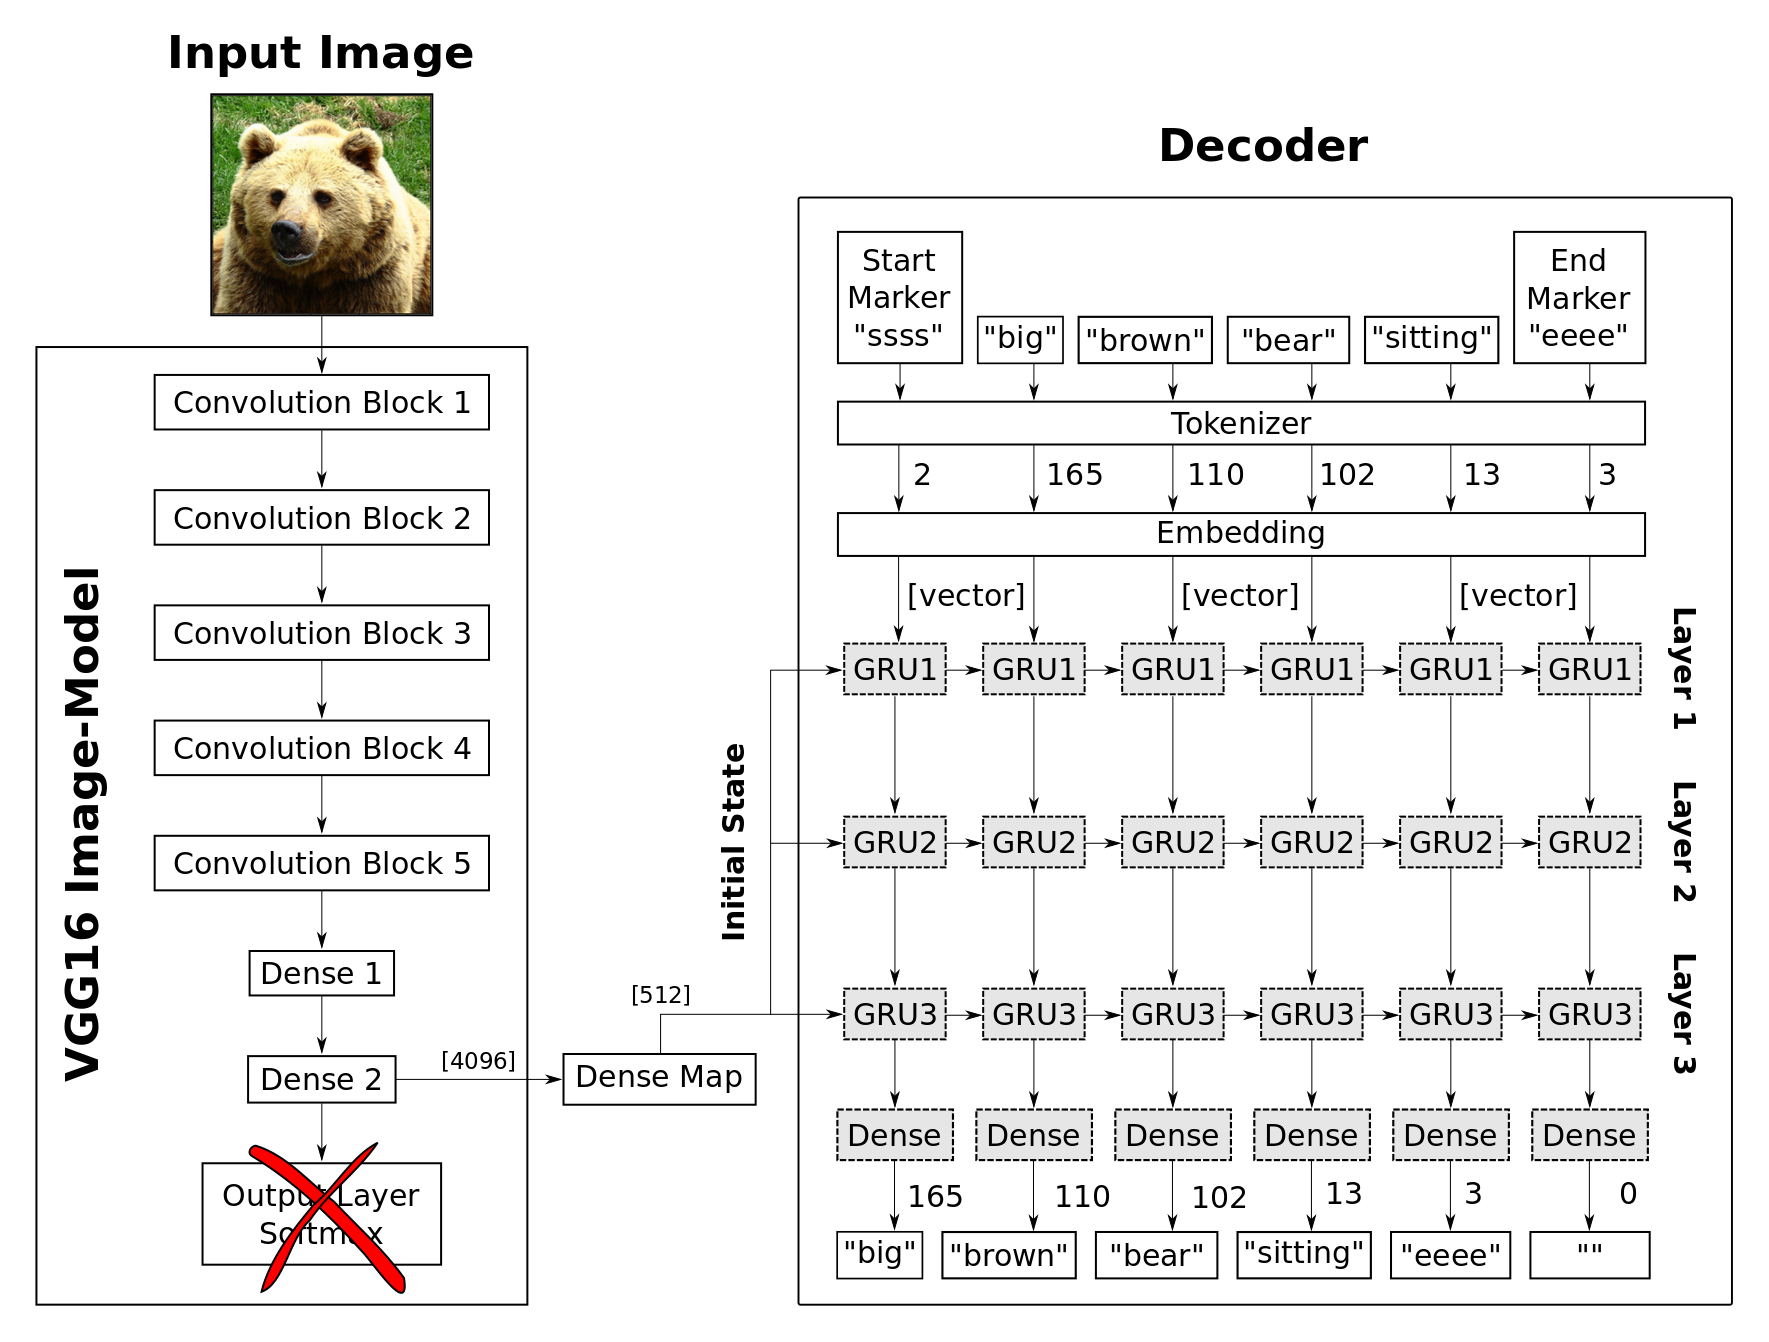

**L'encodeur CNN :**



In [13]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

**Le mécanisme d'attention :**


In [14]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

**Le décodeur RNN :**


In [15]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        #Couche dense qui aura pour entrée la sortie du GRU
        self.fc1 = tf.keras.layers.Dense(units)

        # Dernière couche dense
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention =  BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # L'attention est defini par un modèle a part
        context_vector, attention_weights = self.attention(features, hidden)
        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
#A COMPLETER
        # Concaténation
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passage du vecteur concaténé à la gru
        output, state = self.gru(x)
        
        # Couche dense
        y = self.fc1(output)

        y = tf.reshape(y, (-1, x.shape[2]))
        
        # Couche dense
        y = self.fc2(y)
        
        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

**Combiner la partie encodeur et décodeur :**


In [16]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [17]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()

# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#### Création de checkpoints

In [18]:

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

Reprise de l'entrainement à la bonne epoch

In [19]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## Entrainement

Définition de la loss et de l'optimizer

In [20]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Le code global contenant la boucle d'entrainement est présenté ci-dessous. Cette boucle parcours le jeu de données d'entrainement batch par batch et entraine le réseaux avec ceux-ci.

In [21]:
if is_train_needed :
    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 50 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        # sauvegarde de la perte
        loss_plot.append(total_loss / num_steps)
        print('modulo epoch ' + str(epoch) + ' = ' + str(epoch % 3))
        if epoch % 3 == 0:
            print('saving checkpoint at epoch ' + str(epoch))
            ckpt_manager.save()

        print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                             total_loss/num_steps))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


    # Affichage de la courbe d'entrainement
    plt.plot(loss_plot)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.show()

## Test
La fonction qui permet d'achever une étape d'evaluation pour le test est dans la cellule suivante. 

In [22]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

L'affichage de quelques exemples sur le résultat retourné par l'évaluation. 

Real Caption: <start> a person riding a bike with people sitting on a bench <end>
Prediction Caption: rackets bunny mouth balancing freshener return costumed hat variegated kick plae sugarcane stationery blows shaggy mugs sigh backs cupcakes rackets ponies logs relish cement shaggy sellers cursive ruler blue cover 20th baseball beverage beginning pink bumper worker dear washed lake mounted post


<ipython-input-22-24614b22aba8>:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


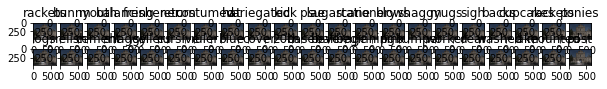

In [23]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

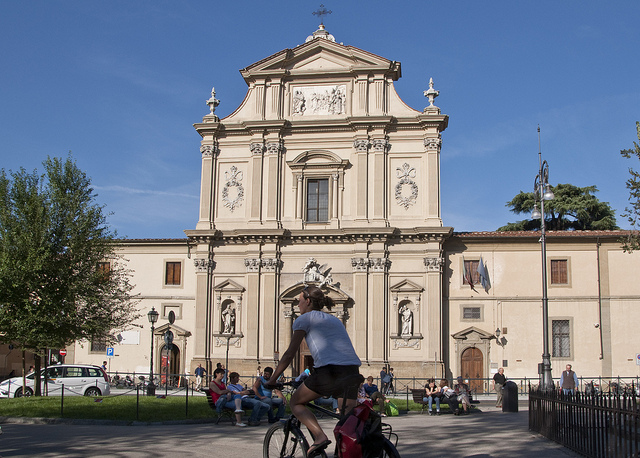

In [24]:
# Image.open(img_name_val[rid])

## Pipeline de test

Mise en place de la pipeline permettant de tester une image de bout en bout

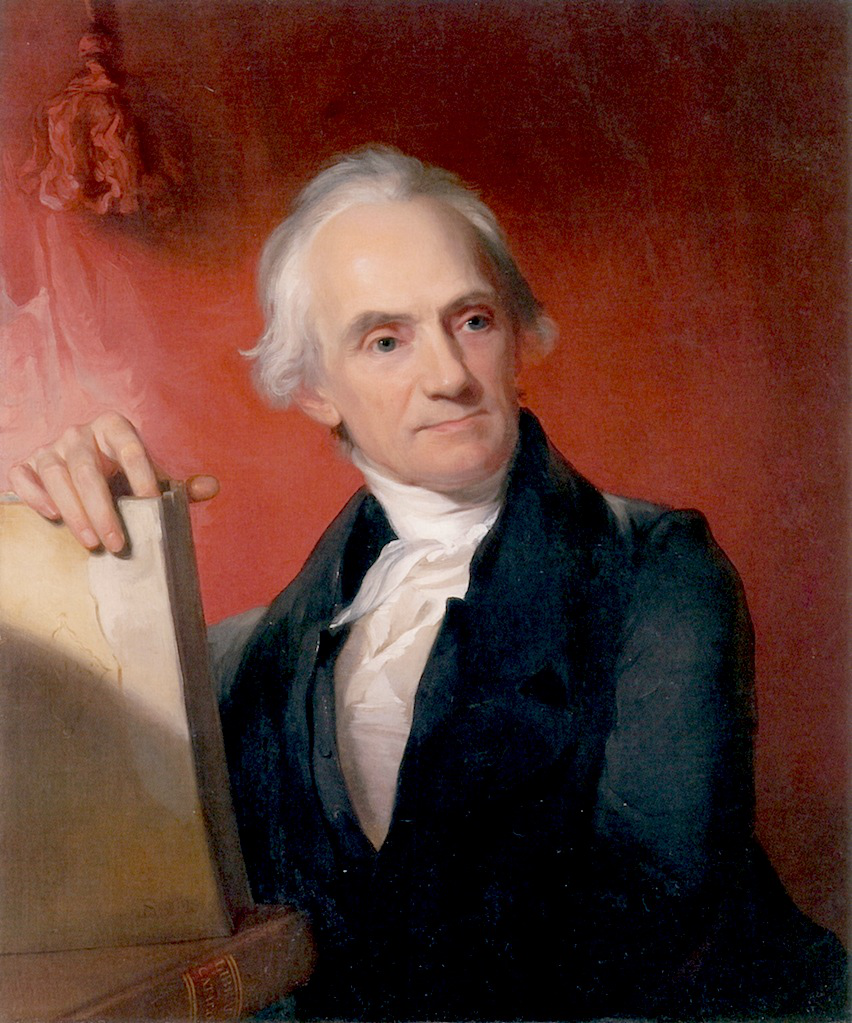

In [38]:
#Selection d'une image aléatoire
image_to_test = random.choice(os.listdir(image_to_test_dir))
image_to_test = os.path.join(image_to_test_dir, image_to_test)
Image.open(image_to_test)

In [39]:
# binary_classifier.predict(image_to_test)

### Debruitage de l'image

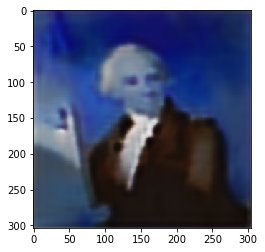

In [40]:
clean_img = denoiser.predict(image_to_test, image_h, image_w)
plt.imshow(clean_img[0], interpolation='nearest')
plt.show()